# TTT4185 Machine learning for Speech technology

## Computer assignment 2: Classification using the Bayes Decision Rule and Support Vector Machines

This assignment assumes that the student has knowledge about the Bayes Decision Rule, maximum likelihood estimation and support vector machines.

In this assignment we will use `scikit-learn` (http://scikit-learn.org/stable/), which is a powerful and very popular Python toolkit for data analysis and machine learning, and `pandas` (https://pandas.pydata.org), which implements the all-powerful `DataFrame`.

In this assigment we will be using a small database of phonemes, where each phoneme is represented by the four first formant positions ("F1"-"F4") and their corresponding bandwidths ("B1"-"B4"). All numbers are in kHz. In addition the speaker ID and the gender of the speaker are given for each phoneme.

### Problem 1

In this problem we will use the Bayes decision rule to classify vowels based on their formants. The formants have been extracted from the open database `VTR Formants database` (http://www.seas.ucla.edu/spapl/VTRFormants.html) created by Microsoft and UCLA.

(a) Download the files `Train.csv` and `Test.csv` from Blackboard, and load them into a `pandas` dataframe using the command `pd.read_csv`. Using the training data, create a single scatter plot of "F1" vs "F2" for the three vowels
- "ae" as in "bat"
- "ey" as in "bait"
- "ux" as in "boot"

Just eyeing the plots, discuss which classes will be hardest to classify correctly.

<IPython.core.display.Javascript object>


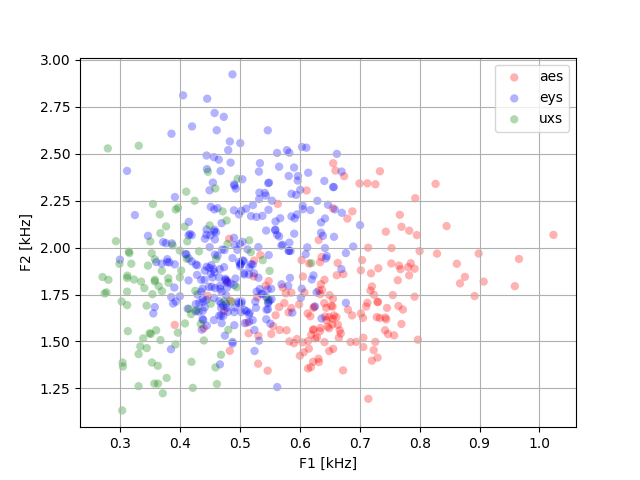

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib notebook


# Load data
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

# Extract vowels
aes = train[train["Phoneme"] == 'ae']
eys = train[train["Phoneme"] == 'ey']
uxs = train[train["Phoneme"] == 'ux']
vowels = [aes, eys, uxs]

# Plotting here
fig, ax = plt.subplots()
colors = ['red', 'blue', 'green']
phoneme_name = ['aes', 'eys', 'uxs']
for idx, vowel in enumerate(vowels):
    x, y = vowel['F1'], vowel['F2']
    color = colors[idx]
    ax.scatter(x, y, c=color, label = phoneme_name[idx],
              alpha=0.3, edgecolors='none')
ax.legend()
ax.set_xlabel('F1 [kHz]')
ax.set_ylabel('F2 [kHz]')
ax.grid(True)
plt.show()


(b) Use the Bayes Decision Rule to create a classifier for the phonemes 'ae', 'ey' and 'ux' under the following constraints:
- The feature vector $x$ contains the first two formants, "F1" and "F2".
- The distribution of $x$ given a phoneme $c$, $P(x|c)$, is Gaussian.
- Use the maximum likelihood estimator to estimate the model parameters.

Test your classifier on the 'ae', 'ey' and 'ux' phonemes from the test set and present your results in a _confusion matrix_, that is, a table where you see how many times 'ae' was correctly classified, how many times it was wrongly classified as 'ey' and so on.

<IPython.core.display.Javascript object>


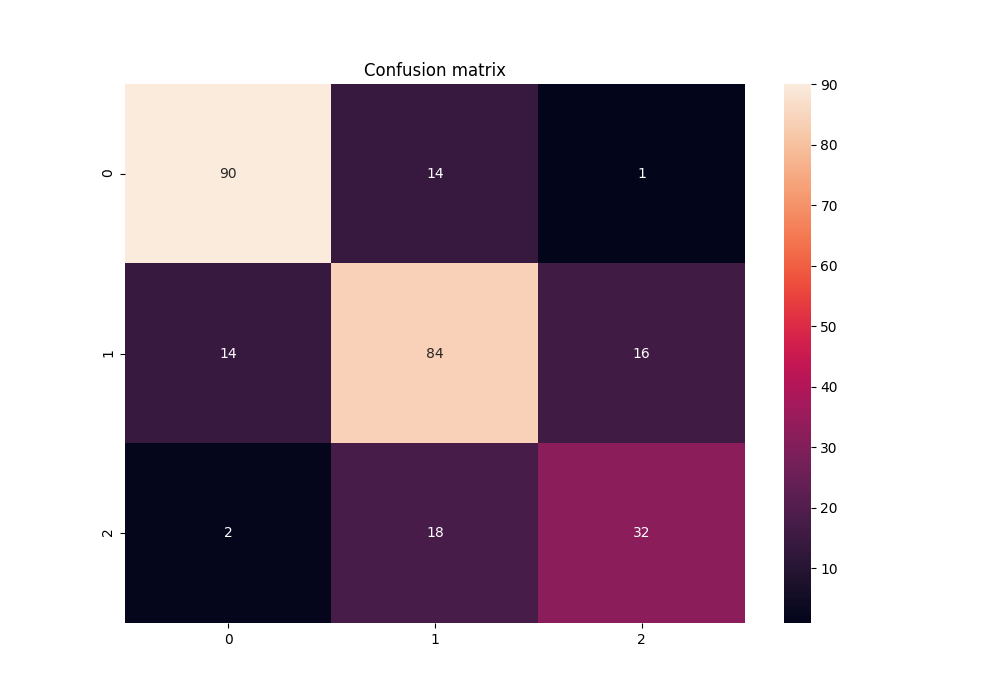

<IPython.core.display.Javascript object>


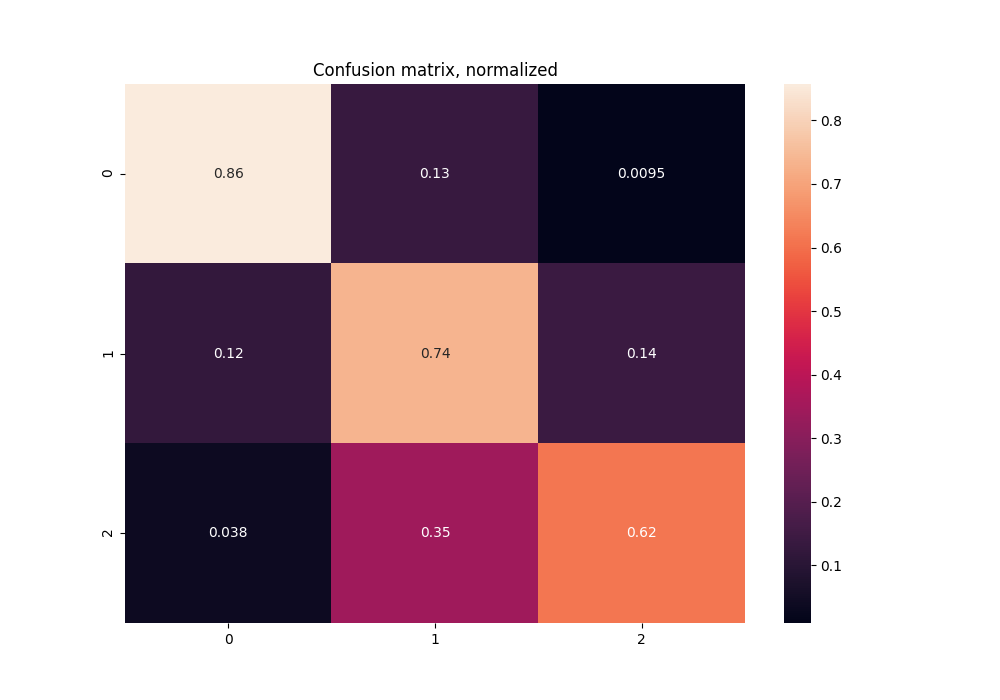

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
# Sizes

n_c = 3

# Memory allocation

N = np.zeros(n_c)
N_tot = 0

priors = np.zeros(n_c)

s_my = (n_c, 2, 1)
my = np.zeros(s_my)

s_cov = (n_c, 2, 2)
cov = np.zeros(s_cov)

# Estimate parameters based on maximum likelihood
for idx, vowel in enumerate(vowels):
    N[idx] = len(vowel)
    N_tot += N[idx]
    my[idx][0] = 1/N[idx] * np.sum(vowel['F1'])
    my[idx][1] = 1/N[idx] * np.sum(vowel['F2'])
    
    F1_vals = vowel['F1']
    F2_vals = vowel['F2']
        
    for val_idx, val in enumerate(F1_vals):
        x_n = np.array([[val], [F2_vals.iloc[val_idx]]])
        dist = (x_n - my[idx])
        cov[idx] += 1/N[idx]*dist.T*dist

for i in range(n_c):
    priors[i] = N[i]/N_tot
    
# The Bayes Decision Rule (BDR) says that an observation x belongs to class k if that class maximizes the 
# probability of observing the observation, 
# i. e. x elem in c_k <=> p(x|c_k)*p(c_k) = maximum wrt. i of p(x|c_i)*p(c_i)

# Choosing a discriminant based classifier, we obtain a discriminant function for
# every class g_k(x) = p(x|c_k)*p(c_k), and thus we get
# x elem in c_k <=> g_k(x) = maximum w.r.t i of g_i(x)

def normal_dist(x_n, my, cov):
    # x must be on the form x = np.array([[x_1], [x_2]])
    coeff = 1/np.sqrt(2*np.pi)*1/np.sqrt(np.linalg.det(cov))
    dist = (x_n - my)
    return coeff*np.exp(-0.5*np.dot(dist.T, (np.dot(np.linalg.inv(cov),dist))))

aes_test = test[test["Phoneme"] == 'ae']
eys_test = test[test["Phoneme"] == 'ey']
uxs_test = test[test["Phoneme"] == 'ux']
vowels_test = [aes_test, eys_test, uxs_test]

# Classify values
classified = []
N_test = np.zeros(n_c)
lh = np.zeros(n_c)

for idx, vowel in enumerate(vowels_test):
    N_test[idx] = len(vowel)
    N_tot += N_test[idx]
    
    F1_vals = vowel['F1']
    F2_vals = vowel['F2']
        
    for val_idx, val in enumerate(F1_vals):
        x_n = np.array([[val], [F2_vals.iloc[val_idx]]])
        for i in range(n_c):
            lh[i] = normal_dist(x_n, my[i], cov[i])
        class_k = np.argmax(lh)
        classified.append(class_k)

a = np.array([0 for i in range(int(N_test[0]))])
b = np.array([1 for i in range(int(N_test[1]))])
c = np.array([2 for i in range(int(N_test[2]))])
true = np.concatenate((a, b, c))
classified = np.array(classified)
result_aes = classified[:int(N_test[0])]
result_eys = classified[int(N_test[0])+1:int(N_test[0] + N_test[1])]
result_uxs = classified[int(N_test[1] + N_test[2]):]

# Confusion matrix
conf_mat = confusion_matrix(true, classified, labels=range(n_c), normalize = None)
df_cm = pd.DataFrame(conf_mat, index = [i for i in range(n_c)],
                  columns = [i for i in range(n_c)])
plt.figure(3, figsize = (10,7))
_ = plt.title('Confusion matrix')
sn.heatmap(df_cm, annot=True)

plt.show()

conf_mat_norm = confusion_matrix(true, classified, labels=range(n_c), normalize = 'true')
df_cm = pd.DataFrame(conf_mat_norm, index = [i for i in range(n_c)],
                  columns = [i for i in range(n_c)])
plt.figure(4, figsize = (10,7))
_ = plt.title('Confusion matrix, normalized')
sn.heatmap(df_cm, annot=True)

plt.show()

*Try:* To visualize the classes models and the classifier created in (b), you can:

- Plot the contours for each Gaussian distribution in the model, that is the class conditional likelihoods $P(x|c)$.
- Plot the decision regions for the Bayesian classifier.

In [3]:
# Kom tilbake til hvis tid

(c) Extend your classifier to include the features "F1"-"F4" and compare the results with those in (b). Finally use all available information "F1"-"F4" and "B1-B4". How does the performance of this classifier compare with the simpler classifiers using fewer features?

<IPython.core.display.Javascript object>


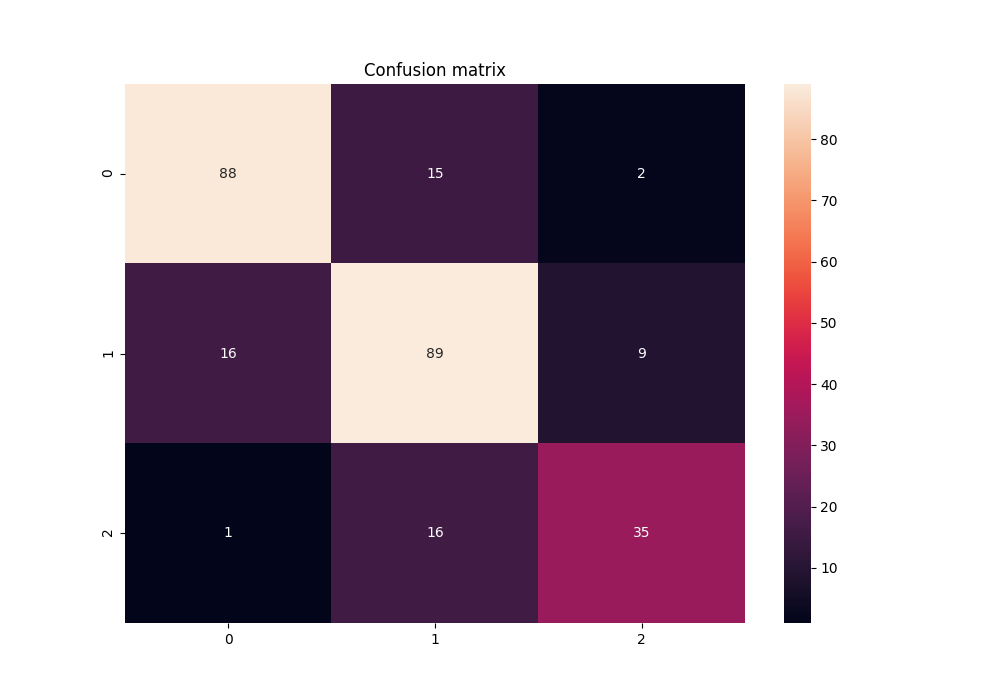

<IPython.core.display.Javascript object>


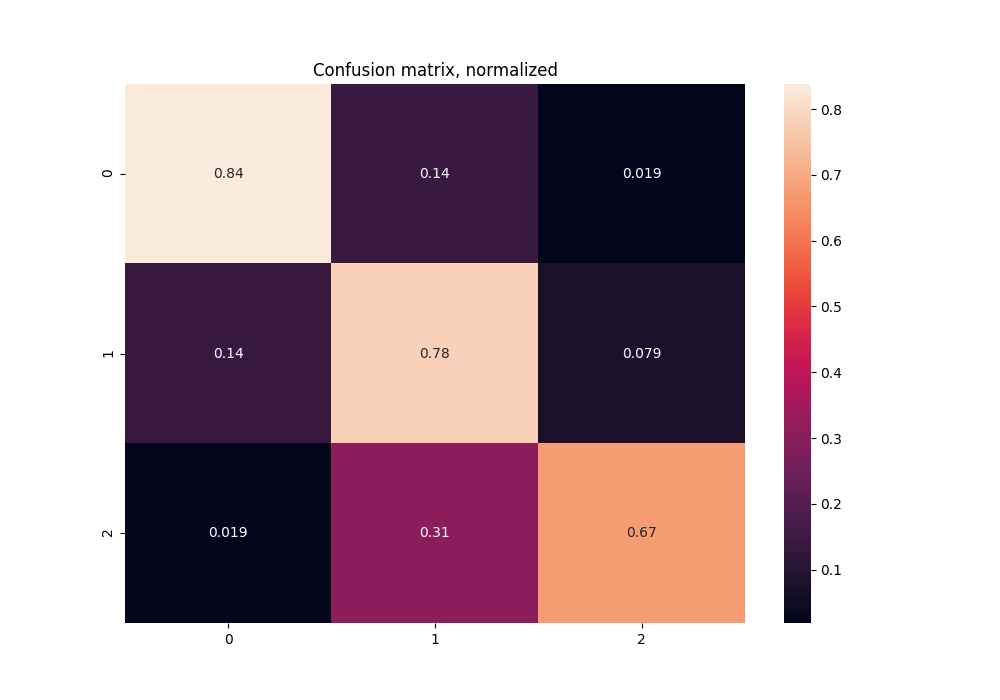

<AxesSubplot:title={'center':'Confusion matrix, normalized'}>

In [4]:
# Memory allocation

N = np.zeros(n_c)
N_tot = 0

priors = np.zeros(n_c)

s_my = (n_c, 4, 1)
my = np.zeros(s_my)

s_cov = (n_c, 4, 4)
cov = np.zeros(s_cov)

# Estimate parameters based on maximum likelihood
for idx, vowel in enumerate(vowels):
    N[idx] = len(vowel)
    N_tot += N[idx]
    my[idx][0] = 1/N[idx] * np.sum(vowel['F1'])
    my[idx][1] = 1/N[idx] * np.sum(vowel['F2'])
    my[idx][2] = 1/N[idx] * np.sum(vowel['F3'])
    my[idx][3] = 1/N[idx] * np.sum(vowel['F4'])
    
    
    F1_vals = vowel['F1']
    F2_vals = vowel['F2']
    F3_vals = vowel['F3']
    F4_vals = vowel['F4']
    
        
    for val_idx, val in enumerate(F1_vals):
        x_n = np.array([[val], [F2_vals.iloc[val_idx]], [F3_vals.iloc[val_idx]], [F4_vals.iloc[val_idx]]])
        dist = (x_n - my[idx])
        cov[idx] += 1/N[idx]*dist.T*dist

for i in range(n_c):
    priors[i] = N[i]/N_tot

def normal_dist(x_n, my, cov):
    coeff = 1/np.sqrt(2*np.pi)*1/np.sqrt(np.linalg.det(cov))
    dist = (x_n - my)
    return coeff*np.exp(-0.5*np.dot(dist.T, (np.dot(np.linalg.inv(cov),dist))))

# Classify values
classified = []
N_test = np.zeros(n_c)
lh = np.zeros(n_c)

for idx, vowel in enumerate(vowels_test):
    N_test[idx] = len(vowel)
    N_tot += N_test[idx]
    
    F1_vals = vowel['F1']
    F2_vals = vowel['F2']
    F3_vals = vowel['F3']
    F4_vals = vowel['F4']
        
    for val_idx, val in enumerate(F1_vals):
        x_n = np.array([[val], [F2_vals.iloc[val_idx]], [F3_vals.iloc[val_idx]], [F4_vals.iloc[val_idx]]])
        for i in range(n_c):
            lh[i] = normal_dist(x_n, my[i], cov[i])
        class_k = np.argmax(lh)
        classified.append(class_k)

classified = np.array(classified)
result_aes = classified[:int(N_test[0])]
result_eys = classified[int(N_test[0])+1:int(N_test[0] + N_test[1])]
result_uxs = classified[int(N_test[1] + N_test[2]):]

# Confusion matrix
conf_mat = confusion_matrix(true, classified, labels=range(n_c), normalize = None)
df_cm = pd.DataFrame(conf_mat, index = [i for i in range(n_c)],
                  columns = [i for i in range(n_c)])
_ = plt.figure(5, figsize = (10,7))
_ = plt.title('Confusion matrix')
sn.heatmap(df_cm, annot=True)

conf_mat_norm = confusion_matrix(true, classified, labels=range(n_c), normalize = 'true')
df_cm = pd.DataFrame(conf_mat_norm, index = [i for i in range(n_c)],
                  columns = [i for i in range(n_c)])
_ = plt.figure(6, figsize = (10,7))
_ = plt.title('Confusion matrix, normalized')
sn.heatmap(df_cm, annot=True)

<IPython.core.display.Javascript object>


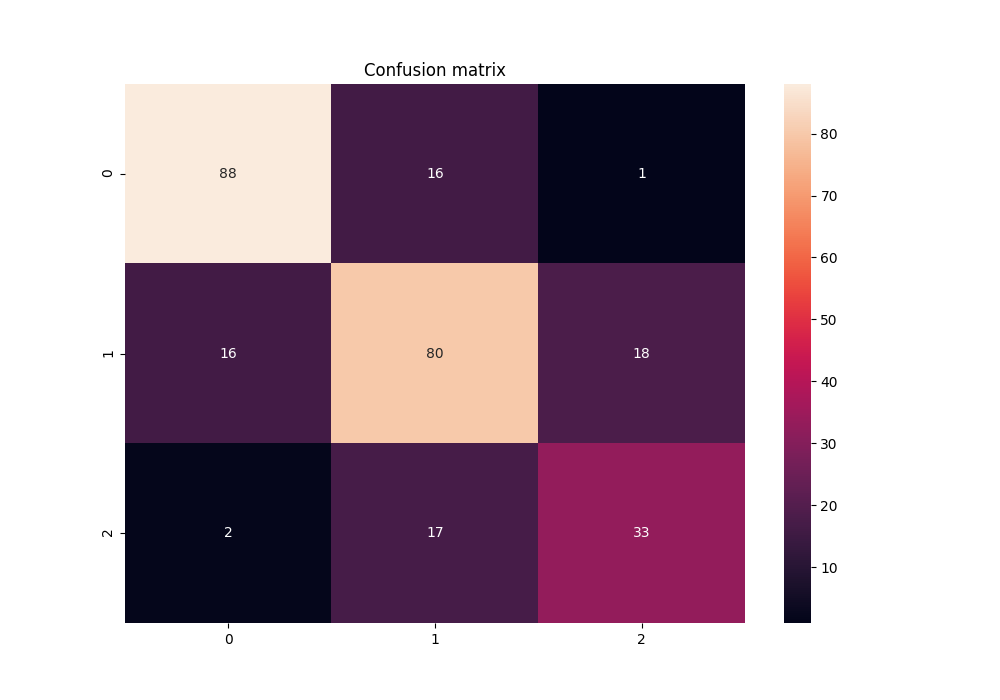

<IPython.core.display.Javascript object>


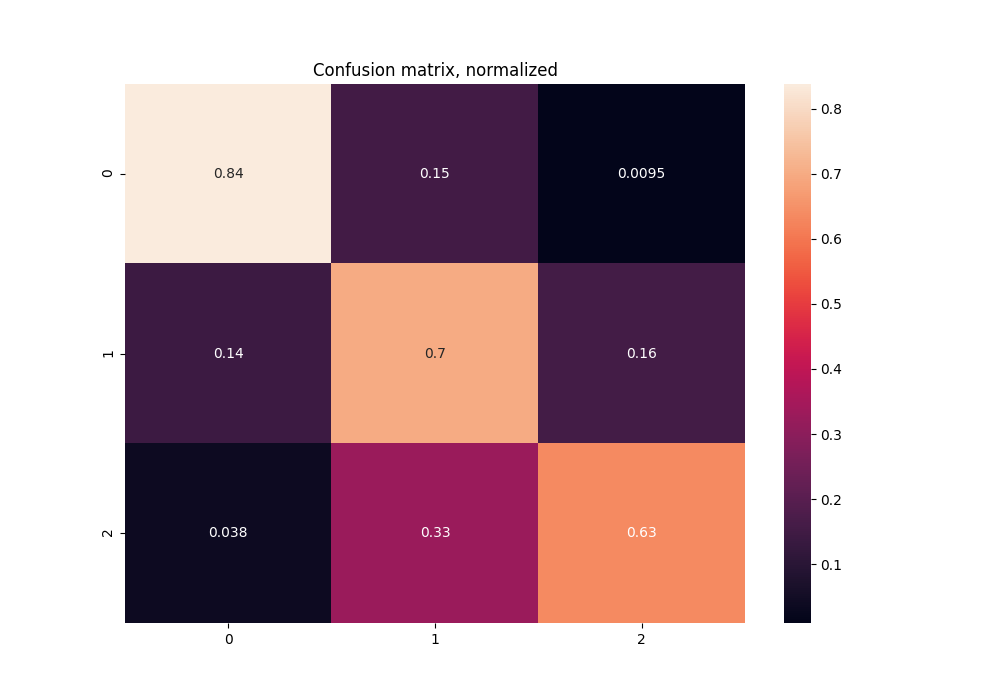

<AxesSubplot:title={'center':'Confusion matrix, normalized'}>

In [5]:
# Memory allocation

N = np.zeros(n_c)
N_tot = 0

priors = np.zeros(n_c)

s_my = (n_c, 8, 1)
my = np.zeros(s_my)

s_cov = (n_c, 8, 8)
cov = np.zeros(s_cov)

# Estimate parameters based on maximum likelihood
for idx, vowel in enumerate(vowels):
    N[idx] = len(vowel)
    N_tot += N[idx]
    
    for i in range(8):
        if i < 4:
            entity = 'F' + str(i + 1)
        else:
            entity = 'B' + str(i - 4 + 1)
        my[idx][i] = 1/N[idx] * np.sum(vowel[entity])

    F1_vals = vowel['F1']
    F2_vals = vowel['F2']
    F3_vals = vowel['F3']
    F4_vals = vowel['F4']
    B1_vals = vowel['B1']
    B2_vals = vowel['B2']
    B3_vals = vowel['B3']
    B4_vals = vowel['B4']
    
        
    for val_idx, val in enumerate(F1_vals):
        x_n = np.array([[val], [F2_vals.iloc[val_idx]], [F3_vals.iloc[val_idx]], [F4_vals.iloc[val_idx]], [B1_vals.iloc[val_idx]], [B2_vals.iloc[val_idx]], [B3_vals.iloc[val_idx]], [B4_vals.iloc[val_idx]]])
        dist = (x_n - my[idx])
        cov[idx] += 1/N[idx]*dist.T*dist

for i in range(n_c):
    priors[i] = N[i]/N_tot

def normal_dist(x_n, my, cov):
    coeff = 1/np.sqrt(2*np.pi)*1/np.sqrt(np.linalg.det(cov))
    dist = (x_n - my)
    return coeff*np.exp(-0.5*np.dot(dist.T, (np.dot(np.linalg.inv(cov),dist))))

# Classify values
classified = []
N_test = np.zeros(n_c)
lh = np.zeros(n_c)

for idx, vowel in enumerate(vowels_test):
    N_test[idx] = len(vowel)
    N_tot += N_test[idx]
    
    F1_vals = vowel['F1']
    F2_vals = vowel['F2']
    F3_vals = vowel['F3']
    F4_vals = vowel['F4']
    B1_vals = vowel['B1']
    B2_vals = vowel['B2']
    B3_vals = vowel['B3']
    B4_vals = vowel['B4']
        
    for val_idx, val in enumerate(F1_vals):
        x_n = np.array([[val], [F2_vals.iloc[val_idx]], [F3_vals.iloc[val_idx]], [F4_vals.iloc[val_idx]], [B1_vals.iloc[val_idx]], [B2_vals.iloc[val_idx]], [B3_vals.iloc[val_idx]], [B4_vals.iloc[val_idx]]])
        for i in range(n_c):
            lh[i] = normal_dist(x_n, my[i], cov[i])
        class_k = np.argmax(lh)
        classified.append(class_k)

classified = np.array(classified)
result_aes = classified[:int(N_test[0])]
result_eys = classified[int(N_test[0])+1:int(N_test[0] + N_test[1])]
result_uxs = classified[int(N_test[1] + N_test[2]):]

# Confusion matrix
conf_mat = confusion_matrix(true, classified, labels=range(n_c), normalize = None)
df_cm = pd.DataFrame(conf_mat, index = [i for i in range(n_c)],
                  columns = [i for i in range(n_c)])
_ = plt.figure(7, figsize = (10,7))
_ = plt.title('Confusion matrix')
sn.heatmap(df_cm, annot=True)

conf_mat_norm = confusion_matrix(true, classified, labels=range(n_c), normalize = 'true')
df_cm = pd.DataFrame(conf_mat_norm, index = [i for i in range(n_c)],
                  columns = [i for i in range(n_c)])
_ = plt.figure(8, figsize = (10,7))
_ = plt.title('Confusion matrix, normalized')
sn.heatmap(df_cm, annot=True)

We see that including F3 and F4 gives (compared to F1, F2 only)

- Worse performance for ae
- Better performance for ey
- Better performance for ux

Including B1-B4 gives (compared to F1, F2 only):

- Worse performance for ae
- Better performance for ey
- Better performance for ux


(d) We want to make the model slightly more powerful by modeling the feature vector conditional on both the vowel and gender of speaker, that is $P(x|g,c)$, where $g$ is the gender of the speaker and $c$ is the phoneme label. Show how these models can be used for phoneme classification using marginalization over the gender.

Assume that $P(x|g,c)$ is a multivariate Gaussian and compute the maximum likelihood estimates for the models. Compare the result on the test set with the results in (c).

<IPython.core.display.Javascript object>


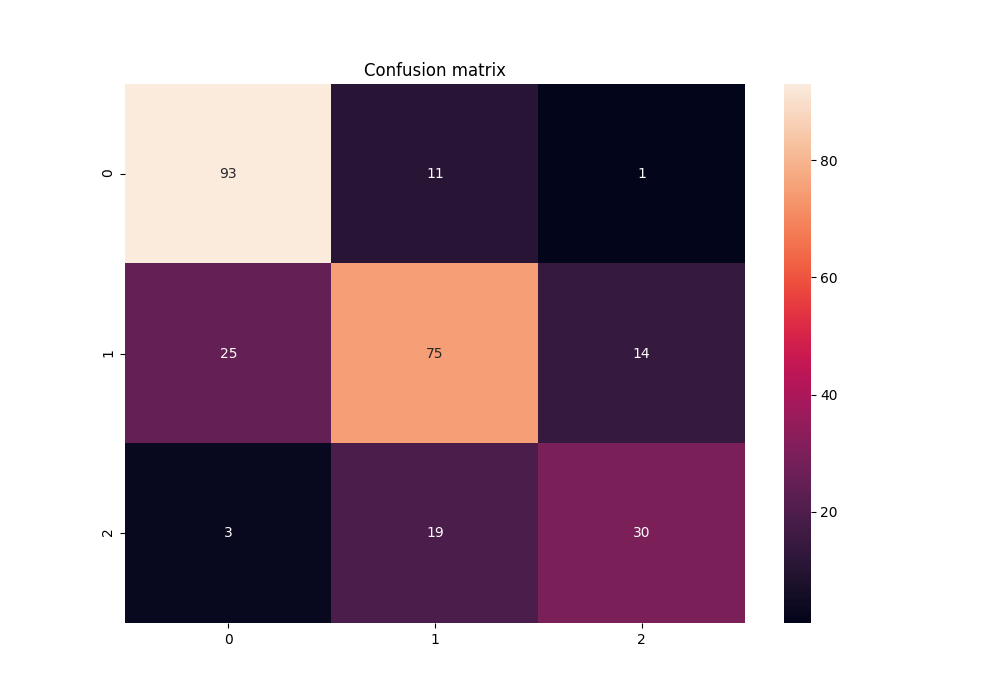

<IPython.core.display.Javascript object>


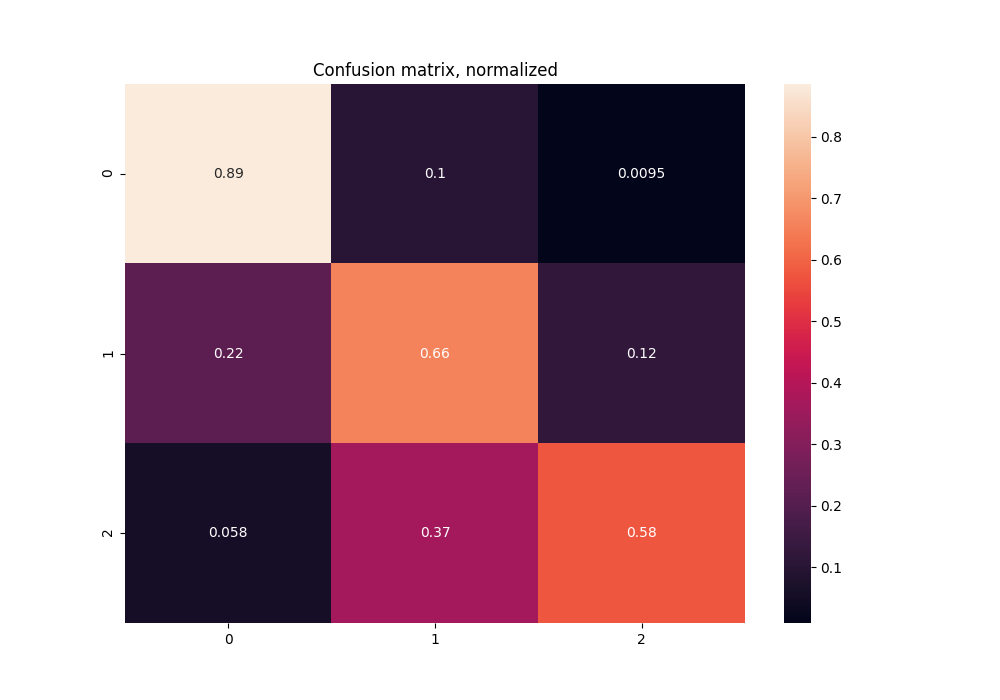

<AxesSubplot:title={'center':'Confusion matrix, normalized'}>

In [6]:
# Now we will have conditional means and covariances based on the gender. 

# Memory allocation

N = np.zeros(n_c)
N_tot = 0

priors = np.zeros(n_c)

s_my = (n_c, 2, 8, 1)
my = np.zeros(s_my)

s_cov = (n_c, 2, 8, 8)
cov = np.zeros(s_cov)

# Estimate parameters based on maximum likelihood
for idx, vowel in enumerate(vowels):
    N[idx] = len(vowel)
    N_tot += N[idx]
    
    female = vowel[vowel['Gender'] == 'F']
    male = vowel[vowel['Gender'] == 'M']
    genders = [female, male]
    
    for g_idx, gender in enumerate(genders):
        for i in range(8):
            if i < 4:
                entity = 'F' + str(i + 1)
            else:
                entity = 'B' + str(i - 4 + 1)
            my[idx][g_idx][i] = 1/N[idx] * np.sum(gender[entity])

        F1_vals = gender['F1']
        F2_vals = gender['F2']
        F3_vals = gender['F3']
        F4_vals = gender['F4']
        B1_vals = gender['B1']
        B2_vals = gender['B2']
        B3_vals = gender['B3']
        B4_vals = gender['B4']

        for val_idx, val in enumerate(F1_vals):
            x_n = np.array([[val], [F2_vals.iloc[val_idx]], [F3_vals.iloc[val_idx]], [F4_vals.iloc[val_idx]], [B1_vals.iloc[val_idx]], [B2_vals.iloc[val_idx]], [B3_vals.iloc[val_idx]], [B4_vals.iloc[val_idx]]])
            dist = (x_n - my[idx][g_idx])
            cov[idx][g_idx] += 1/N[idx]*dist.T*dist

def normal_dist(x_n, my, cov):
    coeff = 1/np.sqrt(2*np.pi)*1/np.sqrt(np.linalg.det(cov))
    dist = (x_n - my)
    return coeff*np.exp(-0.5*np.dot(dist.T, (np.dot(np.linalg.inv(cov),dist))))

# Classify values
classified = []
N_test = np.zeros(n_c)
lh = np.zeros(2*n_c)

for idx, vowel in enumerate(vowels_test):
    N_test[idx] = len(vowel)
    N_tot += N_test[idx]
    
    F1_vals = vowel['F1']
    F2_vals = vowel['F2']
    F3_vals = vowel['F3']
    F4_vals = vowel['F4']
    B1_vals = vowel['B1']
    B2_vals = vowel['B2']
    B3_vals = vowel['B3']
    B4_vals = vowel['B4']
        
    for val_idx, val in enumerate(F1_vals):
        x_n = np.array([[val], [F2_vals.iloc[val_idx]], [F3_vals.iloc[val_idx]], [F4_vals.iloc[val_idx]], [B1_vals.iloc[val_idx]], [B2_vals.iloc[val_idx]], [B3_vals.iloc[val_idx]], [B4_vals.iloc[val_idx]]])
        for i in range(n_c):
            for j in range(2):
                lh[2*i + j] = normal_dist(x_n, my[i][j], cov[i][j])
        class_k = np.argmax(lh)//2
        classified.append(class_k)

classified = np.array(classified)
result_aes = classified[:int(N_test[0])]
result_eys = classified[int(N_test[0])+1:int(N_test[0] + N_test[1])]
result_uxs = classified[int(N_test[1] + N_test[2]):]


# Confusion matrix
conf_mat = confusion_matrix(true, classified, labels=range(n_c), normalize = None)
df_cm = pd.DataFrame(conf_mat, index = [i for i in range(n_c)],
                  columns = [i for i in range(n_c)])
_ = plt.figure(9, figsize = (10,7))
_ = plt.title('Confusion matrix')
sn.heatmap(df_cm, annot=True)

conf_mat_norm = confusion_matrix(true, classified, labels=range(n_c), normalize = 'true')
df_cm = pd.DataFrame(conf_mat_norm, index = [i for i in range(n_c)],
                  columns = [i for i in range(n_c)])
_ = plt.figure(10, figsize = (10,7))
_ = plt.title('Confusion matrix, normalized')
sn.heatmap(df_cm, annot=True)

(e) When using Gaussian classifiers we often avoid computing the entire covariance matrix, but instead we only use the diagonal of the matrix. Repeat the results in (d) using only diagonal covariance matrices and compare the results.

<IPython.core.display.Javascript object>


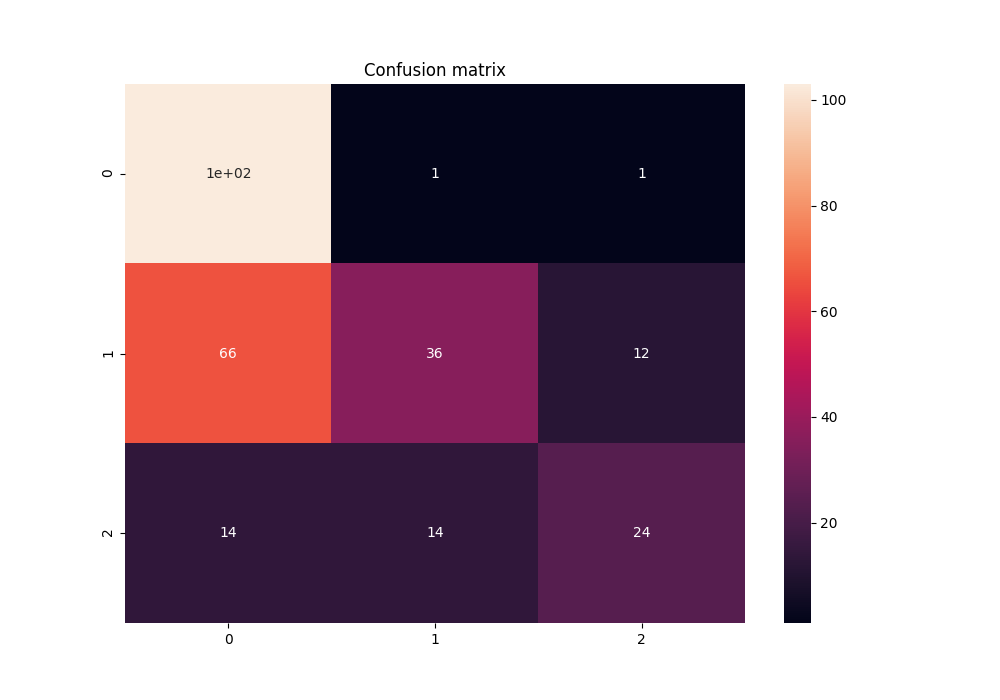

<IPython.core.display.Javascript object>


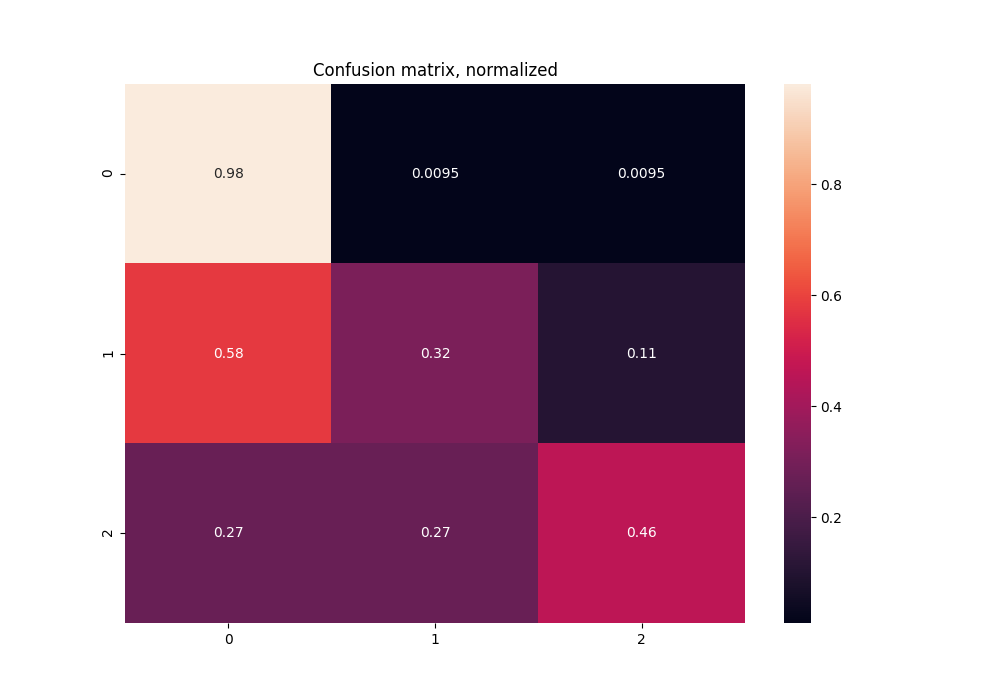

<AxesSubplot:title={'center':'Confusion matrix, normalized'}>

In [7]:
# Now we will have conditional means and covariances based on the gender. 

# Memory allocation

N = np.zeros(n_c)
N_tot = 0

priors = np.zeros(n_c)

s_my = (n_c, 2, 8, 1)
my = np.zeros(s_my)

s_cov = (n_c, 2, 8, 8)
cov = np.zeros(s_cov)

# Estimate parameters based on maximum likelihood
for idx, vowel in enumerate(vowels):
    N[idx] = len(vowel)
    N_tot += N[idx]
    
    female = vowel[vowel['Gender'] == 'F']
    male = vowel[vowel['Gender'] == 'M']
    genders = [female, male]
    
    for g_idx, gender in enumerate(genders):
        for i in range(8):
            if i < 4:
                entity = 'F' + str(i + 1)
            else:
                entity = 'B' + str(i - 4 + 1)
            my[idx][g_idx][i] = 1/N[idx] * np.sum(gender[entity])

        F1_vals = gender['F1']
        F2_vals = gender['F2']
        F3_vals = gender['F3']
        F4_vals = gender['F4']
        B1_vals = gender['B1']
        B2_vals = gender['B2']
        B3_vals = gender['B3']
        B4_vals = gender['B4']

        for val_idx, val in enumerate(F1_vals):
            x_n = np.array([[val], [F2_vals.iloc[val_idx]], [F3_vals.iloc[val_idx]], [F4_vals.iloc[val_idx]], [B1_vals.iloc[val_idx]], [B2_vals.iloc[val_idx]], [B3_vals.iloc[val_idx]], [B4_vals.iloc[val_idx]]])
            dist = (x_n - my[idx][g_idx])
            cov[idx][g_idx] += 1/N[idx]*dist.T*dist
            cov_true = 1/N[idx]*dist.T*dist
            cov[idx][g_idx] += np.diag(np.diag(cov_true))

def normal_dist(x_n, my, cov):
    coeff = 1/np.sqrt(2*np.pi)*1/np.sqrt(np.linalg.det(cov))
    dist = (x_n - my)
    return coeff*np.exp(-0.5*np.dot(dist.T, (np.dot(np.linalg.inv(cov),dist))))

# Classify values
classified = []
N_test = np.zeros(n_c)
lh = np.zeros(2*n_c)

for idx, vowel in enumerate(vowels_test):
    N_test[idx] = len(vowel)
    N_tot += N_test[idx]
    
    F1_vals = vowel['F1']
    F2_vals = vowel['F2']
    F3_vals = vowel['F3']
    F4_vals = vowel['F4']
    B1_vals = vowel['B1']
    B2_vals = vowel['B2']
    B3_vals = vowel['B3']
    B4_vals = vowel['B4']
        
    for val_idx, val in enumerate(F1_vals):
        x_n = np.array([[val], [F2_vals.iloc[val_idx]], [F3_vals.iloc[val_idx]], [F4_vals.iloc[val_idx]], [B1_vals.iloc[val_idx]], [B2_vals.iloc[val_idx]], [B3_vals.iloc[val_idx]], [B4_vals.iloc[val_idx]]])
        for i in range(n_c):
            for j in range(2):
                lh[2*i + j] = normal_dist(x_n, my[i][j], cov[i][j])
        class_k = np.argmax(lh)//2
        classified.append(class_k)

classified = np.array(classified)
result_aes = classified[:int(N_test[0])]
result_eys = classified[int(N_test[0])+1:int(N_test[0] + N_test[1])]
result_uxs = classified[int(N_test[1] + N_test[2]):]


# Confusion matrix
conf_mat = confusion_matrix(true, classified, labels=range(n_c), normalize = None)
df_cm = pd.DataFrame(conf_mat, index = [i for i in range(n_c)],
                  columns = [i for i in range(n_c)])
_ = plt.figure(11, figsize = (10,7))
_ = plt.title('Confusion matrix')
sn.heatmap(df_cm, annot=True)

conf_mat_norm = confusion_matrix(true, classified, labels=range(n_c), normalize = 'true')
df_cm = pd.DataFrame(conf_mat_norm, index = [i for i in range(n_c)],
                  columns = [i for i in range(n_c)])
_ = plt.figure(12, figsize = (10,7))
_ = plt.title('Confusion matrix, normalized')
sn.heatmap(df_cm, annot=True)

### Problem 2

In this problem we use the support vector machine (SVM) to build classifiers. We use the same dataset as in Problem 1. It is up to you to select which features to use.

We use the function `sklearn.svm.SVC` from `scikit-learn` in this problem. First you need to get your data on the format that `SVC` expects, which is a matrix where every row is a feature vector, and a list of integer labels corresponding to each row. We suggest using "ae" = 0, "ey" = 1 and "ux" = 2.

An example on how to use the `SVC` is given in http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC. In short we do the following (for a linear kernel):
- Instantiate an SVC object: `cls = SVC(kernel='linear')`
- Train the SVM using the feature vector matrix `train_X`, and label vector `train_Y`: `cls.fit(train_X, train_Y)`
- Predict labels on the test set `Test_X` using: `cls.predict(Test_X)`

(a) Create a linear SVM with different penalty terms $C=\{0.1, 1, 10\}$ and compare with the results in Problem 1.

<IPython.core.display.Javascript object>


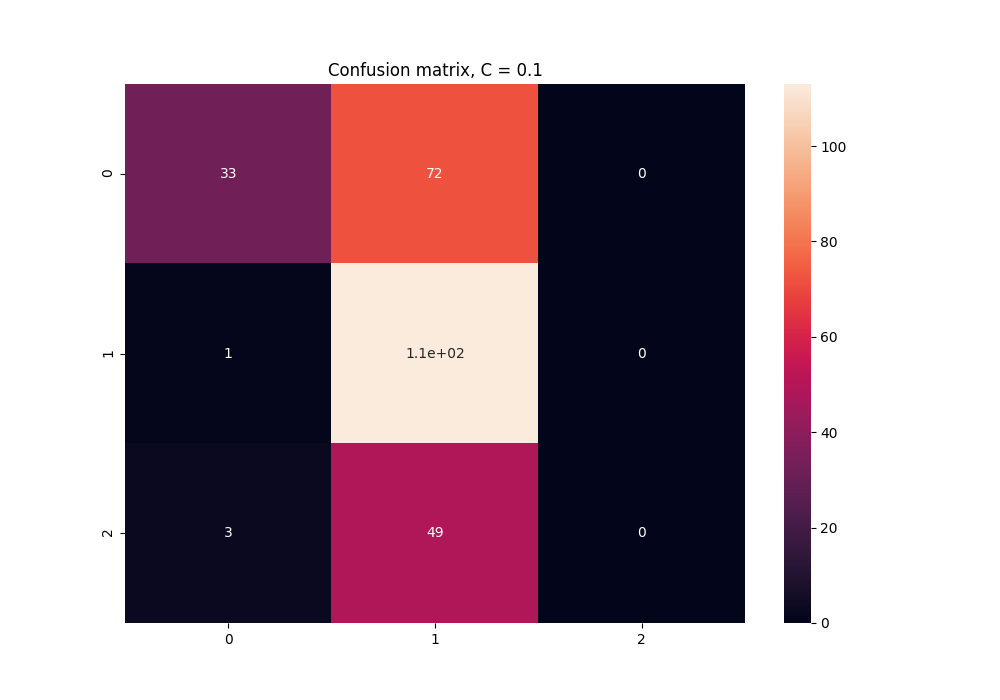

<IPython.core.display.Javascript object>


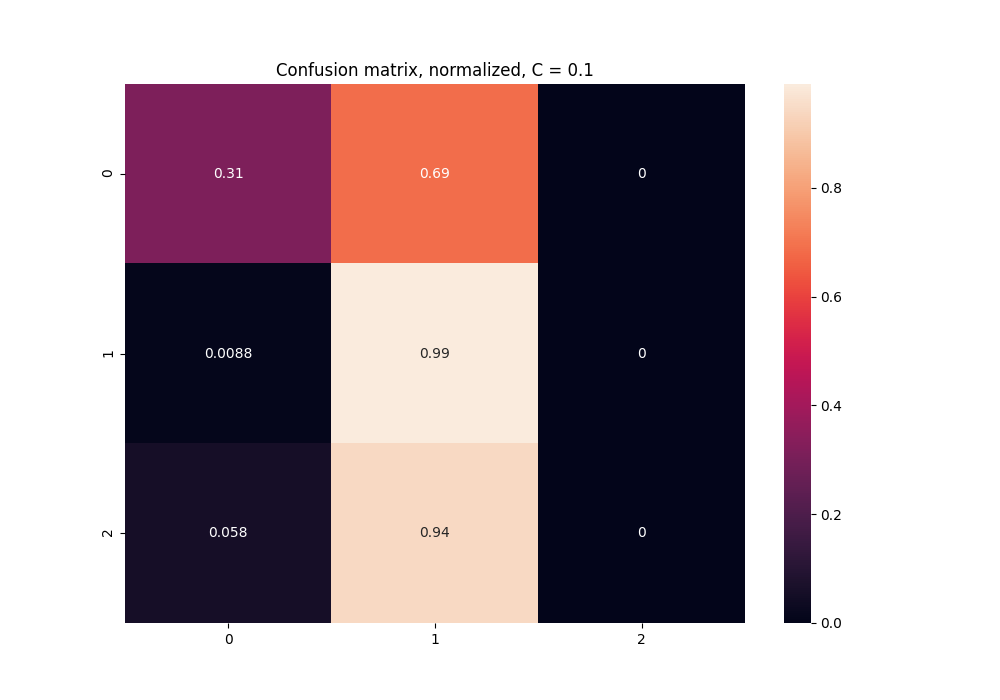

<IPython.core.display.Javascript object>


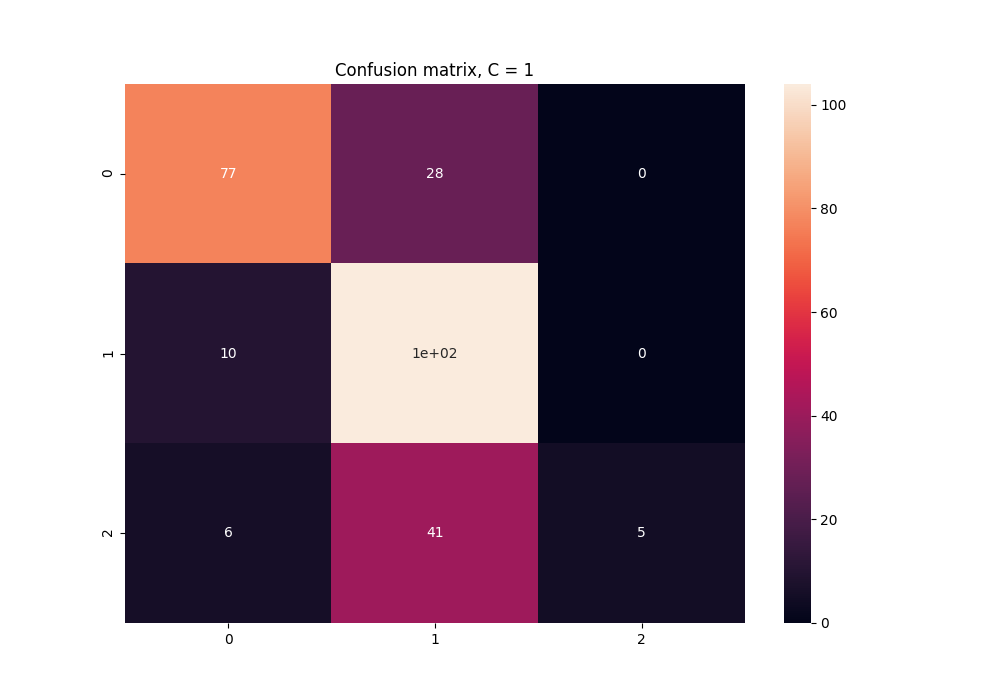

<IPython.core.display.Javascript object>


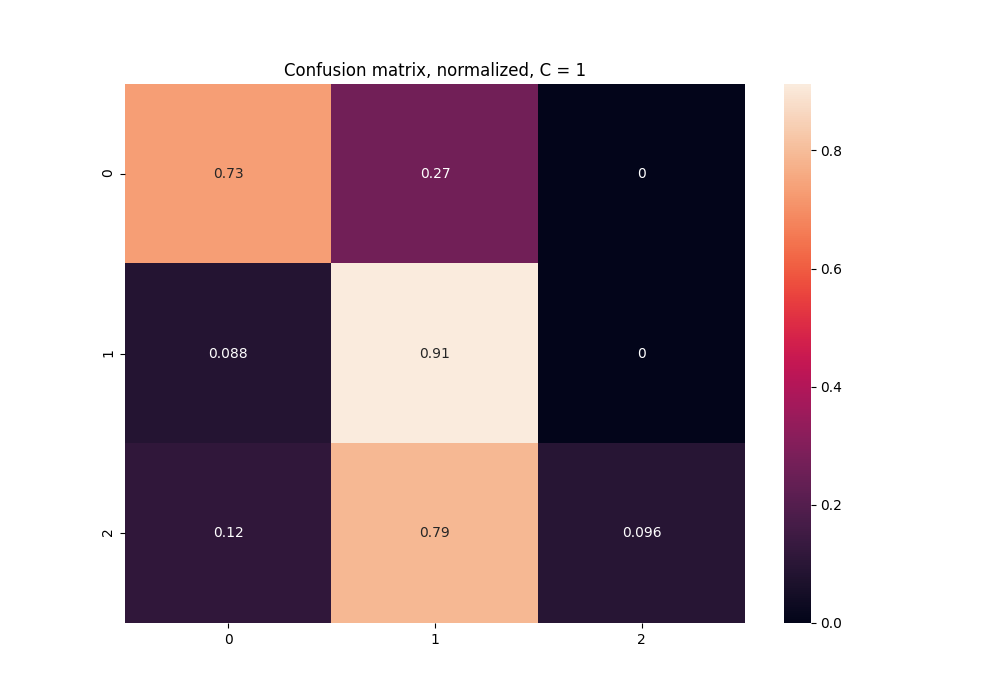

<IPython.core.display.Javascript object>


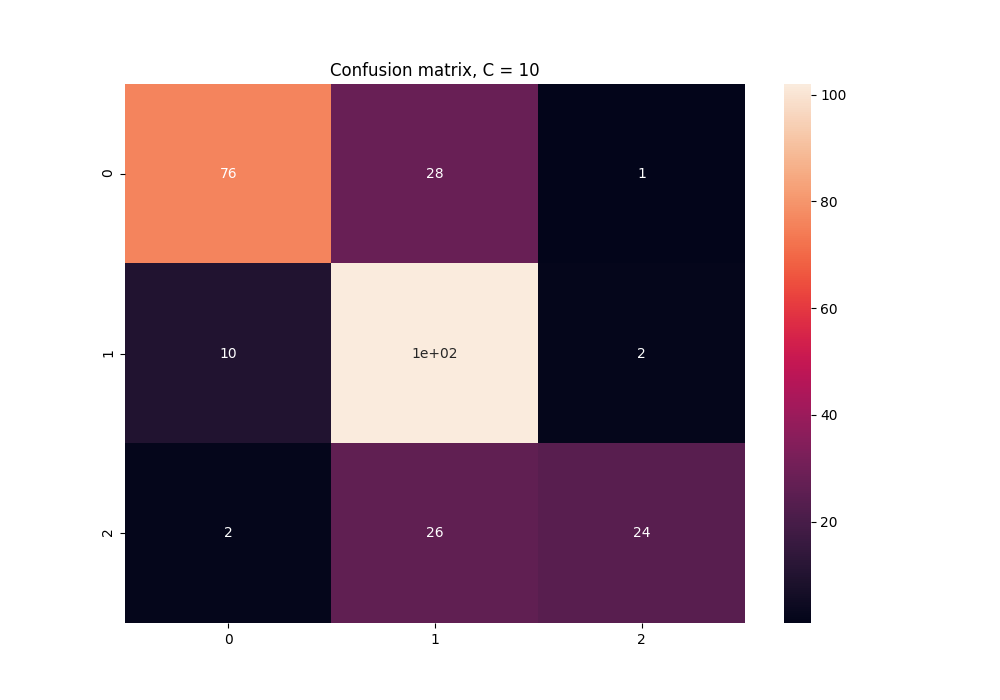

<IPython.core.display.Javascript object>


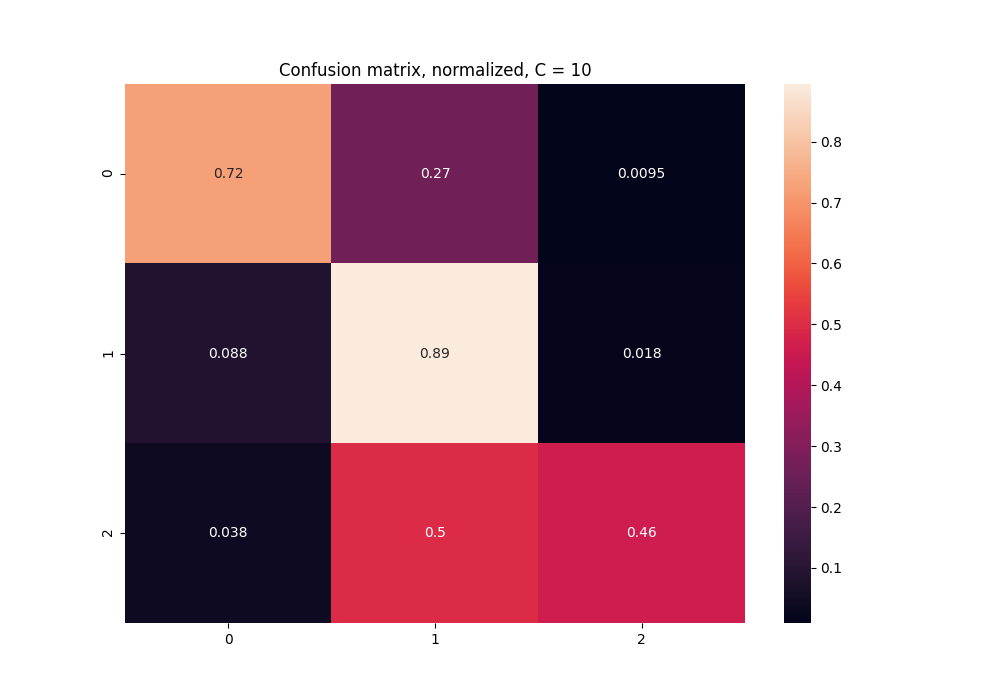

In [8]:
from sklearn import svm

# Adjust data formats

# Training set
aes = train[train["Phoneme"] == 'ae']
eys = train[train["Phoneme"] == 'ey']
uxs = train[train["Phoneme"] == 'ux']
vowels = [aes, eys, uxs]

N_train = np.zeros(n_c)
train_mat = []
for idx, vowel in enumerate(vowels):
    F1_vals = vowel['F1']
    F2_vals = vowel['F2']
    F3_vals = vowel['F3']
    F4_vals = vowel['F4']
    B1_vals = vowel['B1']
    B2_vals = vowel['B2']
    B3_vals = vowel['B3']
    B4_vals = vowel['B4']
    
    N_train[idx] = len(vowel)
    for i in range(int(N_train[idx])):
        x_n = [F1_vals.iloc[i],
                F2_vals.iloc[i],
                F3_vals.iloc[i],
                F4_vals.iloc[i],
                B1_vals.iloc[i],
                B2_vals.iloc[i],
                B3_vals.iloc[i],
                B4_vals.iloc[i]]
        train_mat.append(x_n)
a = np.array([0 for i in range(int(N_train[0]))])
b = np.array([1 for i in range(int(N_train[1]))])
c = np.array([2 for i in range(int(N_train[2]))])
targets = np.concatenate((a, b, c))

# Test set
aes_test = test[test["Phoneme"] == 'ae']
eys_test = test[test["Phoneme"] == 'ey']
uxs_test = test[test["Phoneme"] == 'ux']
vowels_test = [aes_test, eys_test, uxs_test]

N_test = np.zeros(n_c)
test_mat = []
for idx, vowel in enumerate(vowels_test):
    F1_vals = vowel['F1']
    F2_vals = vowel['F2']
    F3_vals = vowel['F3']
    F4_vals = vowel['F4']
    B1_vals = vowel['B1']
    B2_vals = vowel['B2']
    B3_vals = vowel['B3']
    B4_vals = vowel['B4']
    
    N_test[idx] = len(vowel)
    for i in range(int(N_test[idx])):
        x_n = [F1_vals.iloc[i],
                F2_vals.iloc[i],
                F3_vals.iloc[i],
                F4_vals.iloc[i],
                B1_vals.iloc[i],
                B2_vals.iloc[i],
                B3_vals.iloc[i],
                B4_vals.iloc[i]]
        test_mat.append(x_n)

#Create svm classifiers
clf_01 = svm.SVC(C = 0.1, kernel='linear') # Linear Kernel
clf_1 = svm.SVC(C = 1, kernel='linear') # Linear Kernel
clf_10 = svm.SVC(C = 10, kernel='linear') # Linear Kernel

#Train the models using the training sets
clf_01.fit(train_mat, targets)
clf_1.fit(train_mat, targets)
clf_10.fit(train_mat, targets)

#Predict the response for test dataset
pred_01 = clf_01.predict(test_mat)
pred_1 = clf_1.predict(test_mat)
pred_10 = clf_10.predict(test_mat)

c_vals = [0.1, 1, 10]
preds = [pred_01, pred_1, pred_10]

# Confusion matrix
for idx, val in enumerate(c_vals):
    conf_mat = confusion_matrix(true, preds[idx], labels=range(n_c), normalize = None)
    df_cm = pd.DataFrame(conf_mat, index = [i for i in range(n_c)],
                      columns = [i for i in range(n_c)])
    _ = plt.figure(13 + 2*idx, figsize = (10,7))
    title = 'Confusion matrix, C = ' + str(val)
    _ = plt.title(title)
    sn.heatmap(df_cm, annot=True)

    conf_mat_norm = confusion_matrix(true, preds[idx], labels=range(n_c), normalize = 'true')
    df_cm = pd.DataFrame(conf_mat_norm, index = [i for i in range(n_c)],
                      columns = [i for i in range(n_c)])
    _ = plt.figure(14 + 2*idx, figsize = (10,7))
    title = 'Confusion matrix, normalized, C = ' + str(val)
    _ = plt.title(title)
    sn.heatmap(df_cm, annot=True)




(b) Try different kernels ('rbf', 'poly', 'sigmoid') and compare the results. Choose one of the kernels and use different penalty terms $C$. What happens with the performance on the training set when you increase $C$? What happens with the performance on the test set?

<IPython.core.display.Javascript object>


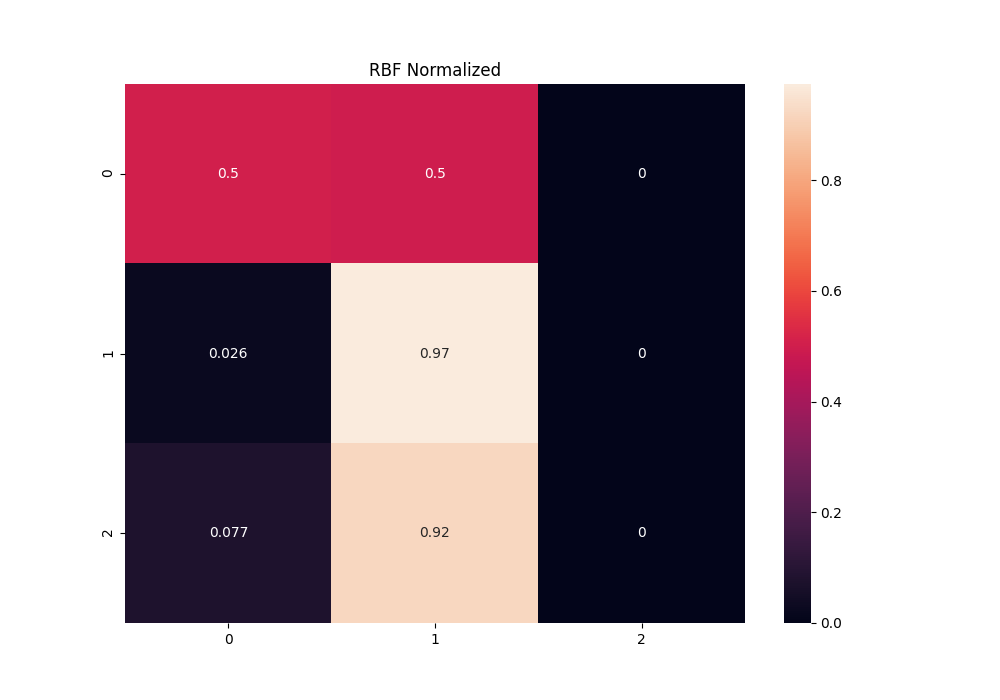

<IPython.core.display.Javascript object>


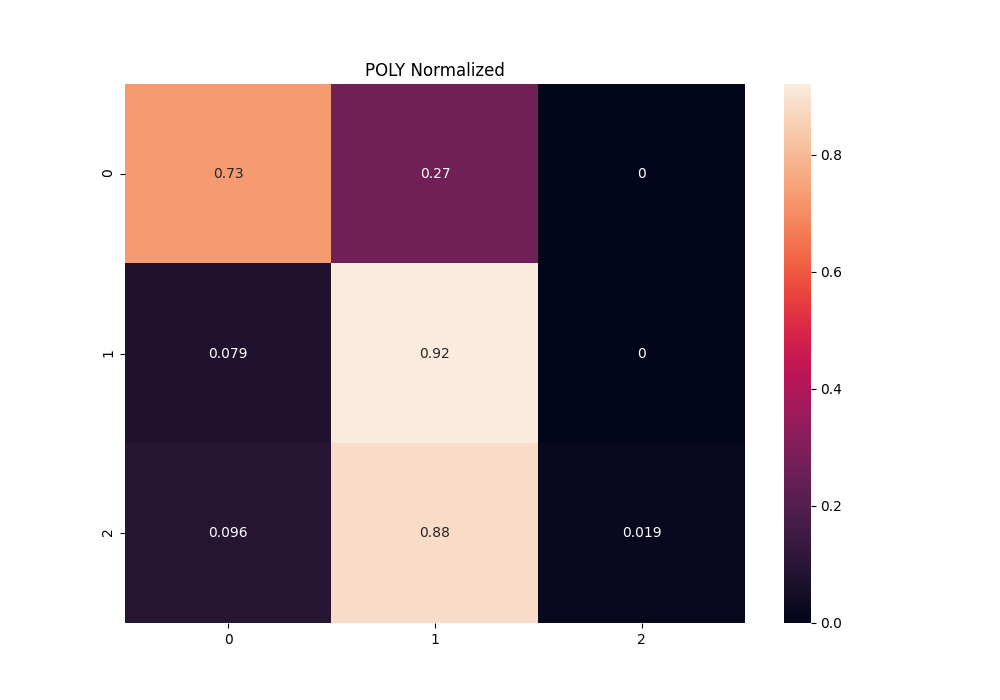

<IPython.core.display.Javascript object>


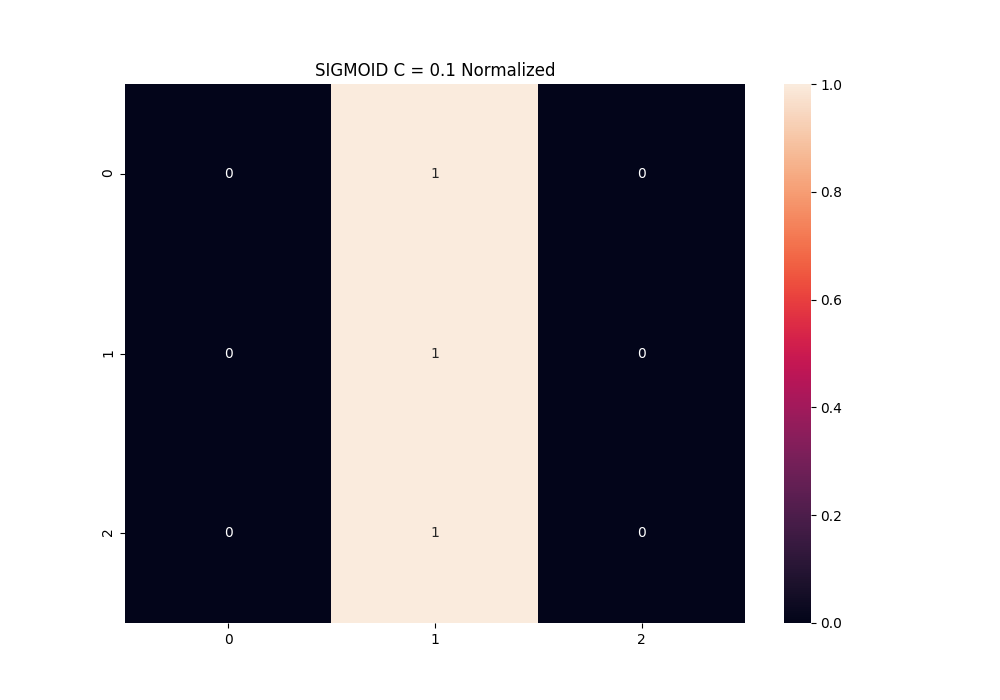

/Users/hannahjelmeland/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


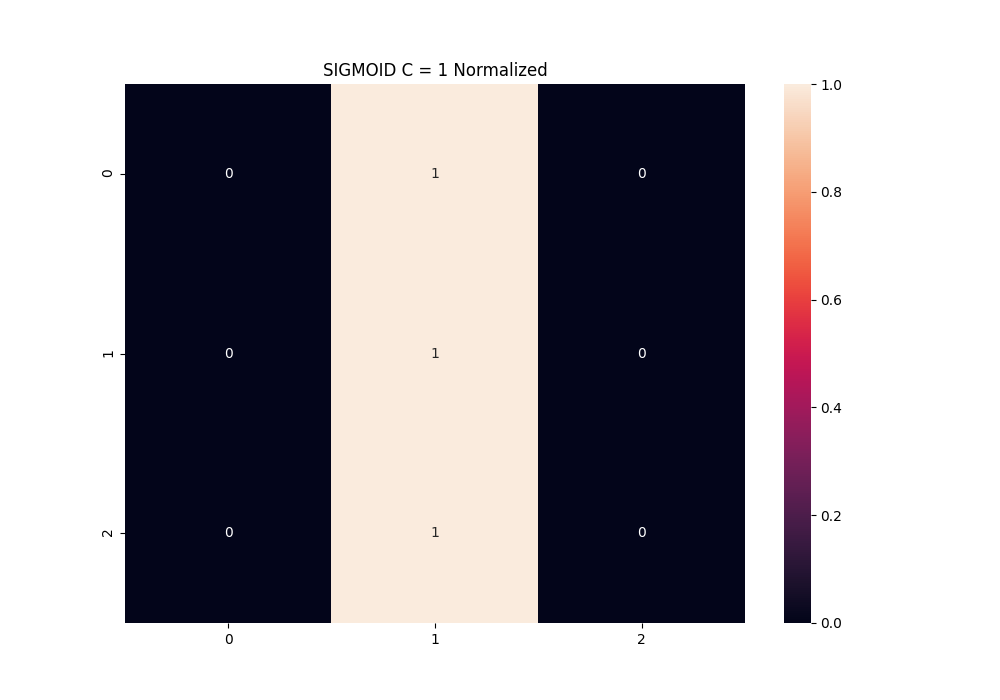

<IPython.core.display.Javascript object>


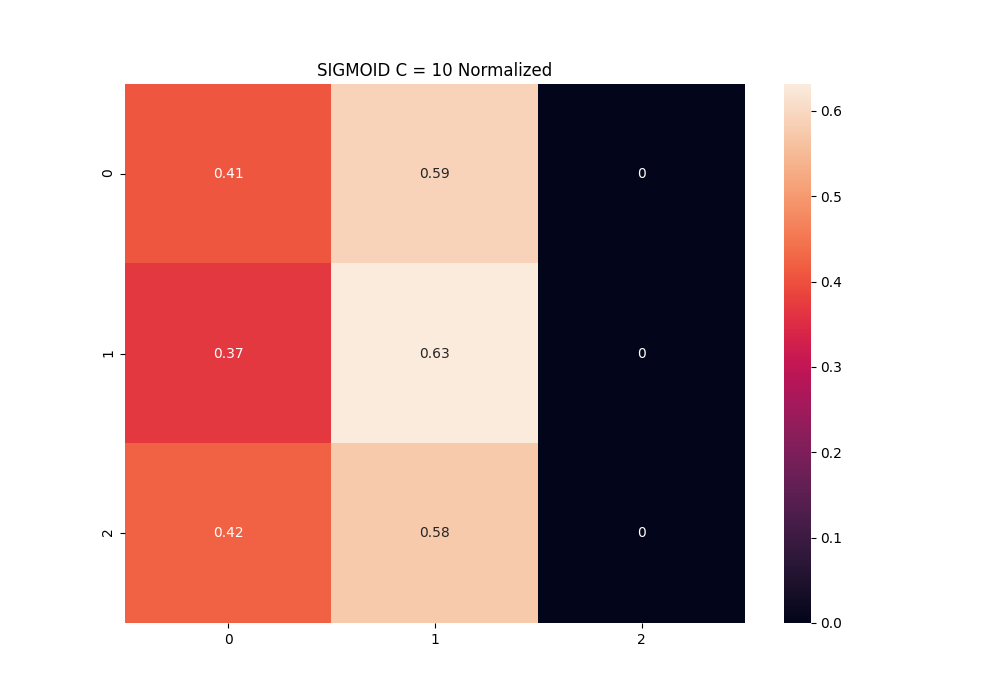

In [9]:
#Create svm classifiers
clf_rbf = svm.SVC(C = 1, kernel='rbf') 
clf_poly = svm.SVC(C = 1, kernel='poly')

clf_sigmoid_01 = svm.SVC(C = 0.1, kernel='sigmoid') 
clf_sigmoid_1 = svm.SVC(C = 1, kernel='sigmoid') 
clf_sigmoid_10 = svm.SVC(C = 10, kernel='sigmoid') 

#Train the models using the training sets
clf_rbf.fit(train_mat, targets)
clf_poly.fit(train_mat, targets)

clf_sigmoid_01.fit(train_mat, targets)
clf_sigmoid_1.fit(train_mat, targets)
clf_sigmoid_10.fit(train_mat, targets)

#Predict the response for test dataset
pred_rbf = clf_rbf.predict(test_mat)
pred_poly = clf_poly.predict(test_mat)
pred_s_01 = clf_sigmoid_01.predict(test_mat)
pred_s_1 = clf_sigmoid_1.predict(test_mat)
pred_s_10 = clf_sigmoid_10.predict(test_mat)

title_vals = ['RBF', 'POLY', 'SIGMOID C = 0.1', 'SIGMOID C = 1', 'SIGMOID C = 10']
preds = [pred_rbf, pred_poly, pred_s_01, pred_s_1, pred_s_10]
    
# Confusion matrix (only normalized)
for idx, val in enumerate(title_vals):
    conf_mat_norm = confusion_matrix(true, preds[idx], labels=range(n_c), normalize = 'true')
    df_cm = pd.DataFrame(conf_mat_norm, index = [i for i in range(n_c)],
                      columns = [i for i in range(n_c)])
    _ = plt.figure(20 + 2*idx, figsize = (10,7))
    _ = plt.title(val + ' Normalized')
    sn.heatmap(df_cm, annot=True)
    
    plt.show()
